Part1 - Boundary Attack

Reporting To: Dr. Alex Vakanski

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Introduction

In this notebook we will be learning how to do 4 tasks with Tensorflow/Keras:


1. Train a deep learning model using transfer learning on the FIne-GRained Image Memorability FIGRIM data set.
2. Implement black-box evasion "Boundary" attacks againts the model we trained.
3. Implement a targeted boundary attack against the trained model.
4. Plot the adversarial image with the predicted label by the classifier.

The tasks will be divided into separate sections, each with detailed descriptions of the methods employed to execute them. The purpose of this notebook is to provide beginners with a guide to the techniques utilized in the adversarial machine learning domain. With the knowledge gained here, you should be able to implement other attacks or defenses.

### Requirments 
Please install the following. Make sure the versions are all up to date.

* Tensorflow 
* Numpy
* OpenCV
* Sklearn
* Matplotlib
* Natsort
* Adversarial Robustness Toolbox

Please note that "Adversarial Robustness Toolbox" can cause error in their latest version for some adversarial attack. But in this notebook I've used 1.13.1 and it worked without causing any issue.




In [ ]:
# Import libraries
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# This line is important, without it the attacks in the ART toolbox won't work
# And it needs to be run before training the models
tf.compat.v1.disable_eager_execution()

# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))

TensorFlow version:2.11.0
Keras version:2.11.0


In [ ]:
# Uncompress the dataset 
!unzip -uq "drive/MyDrive/AML_Course/Assignment_2/SCENES_700x700.zip" -d "sample_data/"

## Data Preprocessing
Data preprocessing is a critical step in machine learning as it can significantly impact the accuracy and reliability of the model's predictions. Here at first we're going to load the data in then preprocess them according to our needs. The comments are provided to have better understanding of what is happening for specific line of the code.






In [ ]:
# Function to load the images and the labels from the dataset
def load_images_and_labels(directory):

    imgs_list = []
    labels_list = []

    # List of all subfolders in the directory
    subfolders_list_1 = listdir(directory)
    # Make sure that the subfolders are sorted 
    subfolders_list = natsort.natsorted(subfolders_list_1)

    # Assign a label to each folder with images (0 to the first folder)
    lab = 0
    for subfolder_name in subfolders_list:
        sub_dir_path = directory + '/' + subfolder_name

        # Read the images as numpy arrays
        imagesList = listdir(sub_dir_path)
        for i in range(len(imagesList)):
          tmp_img = cv2.imread(os.path.join(sub_dir_path, imagesList[i]))
          # Resize all images to 224 x 224 pixels
          resized_img = cv2.resize(tmp_img, (224, 224)) 
          img_arr = np.array(resized_img)
          imgs_list.append(img_arr.astype(float))
          labels_list.append(lab)
        lab += 1
    
    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)
    labels = np.asarray(labels_list)

    return imgs, labels

# Use the above function to load the images and labels
all_images, all_labels = load_images_and_labels('sample_data/SCENES_700x700')

This code snippet below is splitting a dataset into three sets: training set, validation set, and test set. The dataset is composed of images and labels, which are stored in two arrays: `all_images` and `all_labels`.

The `train_test_split()` function from the scikit-learn library is used to perform the split.

The first line of code splits the dataset into a train/validation set and a test set. trainval_images and trainval_labels will contain 80% of the original data, randomly selected, while test_images and test_labels will contain the remaining 20%.

The second line of code splits the train/validation set into a training set and a validation set. `train_images` and `train_labels` will contain 64% of the original data (80% of 80%), randomly selected, while `val_images` and `val_labels` will contain the remaining 16% (20% of 80%).

Finally, the last line of code deletes the `all_images` array, because it is no longer needed after the split.



In [ ]:
# Split into train, test, and validation sets
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=11)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=12)
del all_images

In [ ]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images 
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

# Note that the images are in the [0,255] range, to keep the data consistent with the notebook example of the attack

# In the example, the mean channel values of the images were subtracted: you don't need to apply that, unless you wish to

Images train shape: (2838, 224, 224, 3) - Labels train shape: (2838,)
Images validation shape: (710, 224, 224, 3) - Labels validation shape: (710,)
Images test shape: (888, 224, 224, 3) - Labels test shape: (888,)

Max pixel value 255.0
Min pixel value 0.0
Average pixel value 121.04675598974063
Data type float64


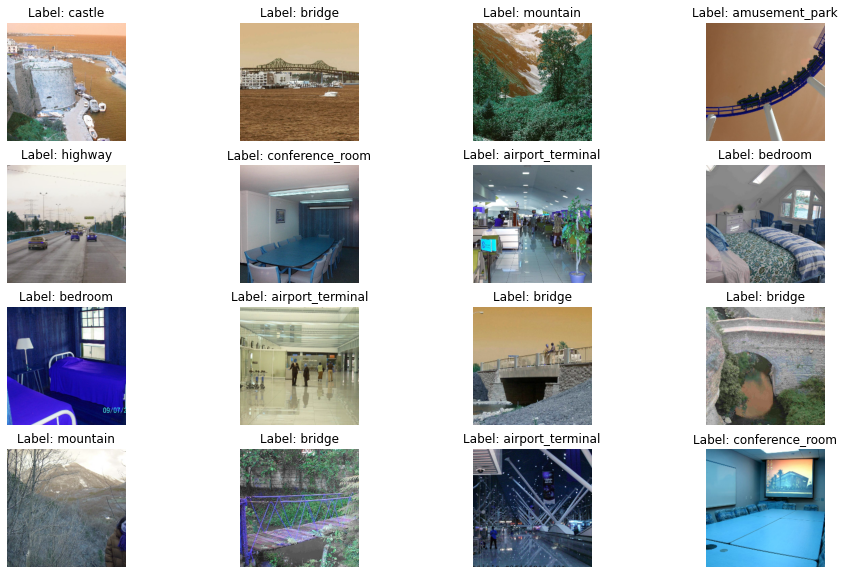

In [ ]:
# A list with the names of the image classes
label_names = ['airport_terminal', 'amusement_park', 'bedroom', 'bridge', 'castle', 'conference_room',
               'golf_course', 'highway', 'mountain', 'playground']
               
# Plot a few images to check if the labels make sense
plt.figure(figsize=(16, 10))
for n in range(16):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(4, 4, n+1)
    plt.imshow(train_images[i[0]].astype(int))
    plt.title('Label: ' + str(label_names[train_labels[i[0]]]))
    plt.axis('off')

In [ ]:
NUM_CLASSES = 10  # Number of labels or classes for classification 

train_labels_onehot = to_categorical(train_labels, NUM_CLASSES)
val_labels_onehot = to_categorical(val_labels, NUM_CLASSES)
test_labels_onehot = to_categorical(test_labels, NUM_CLASSES)

# Remember:
# 1. If you use one-hot vectors for the labels, the loss function in the model needs to be 'categorical_crossentropy'
# 2. If you use a single class value for the labels, the loss in the model needs to be 'sparse_categorical_crossentropy'

## Part 1 - Train a deep learning model using transfer learning on the FIGRIM data set.

At first we're going to define some of the basic varibalbes which will be used in our model. `BATCH_SIZE` refers to the number of samples that are processed by the model at a time during the training process, in this case we are passing 128 samples. This number can be changed according to the needs. Since we're going to use the color images therefore `N_CHANNEL` refers 3 (R,G,B). Every line of the code have their comments for explaining the purpose of it. 

In [ ]:
BATCH_SIZE = 128                            # Size of batch
HEIGHT = 224                                 # Height of input image
WIDTH = 224                                  # Width of input image
N_CHANNEL = 3                               # Number of channels
OUTPUT_DIM = 10                            # Number of output dimension

# Set training hyperparameters
NUM_EPOCH = 50                             # Number of epoch to train
LR = 0.0001                                 # Learning rate
RBW = False #restore best weights
PATIENCE = 5 # how many epochs between improvements

INPUT_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)  # Input shape of model
IMG_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)

## Early Stopping
This code sets up an early stopping callback for a machine learning model using the Keras library in TensorFlow. The purpose of the callback is to monitor the validation loss during the training process and stop the training process if the validation loss does not improve for a certain number of epochs, referred to as PATIENCE.

`monitor`: This parameter specifies the quantity to be monitored during the training process. In this case, the validation loss (`val_loss`) is monitored, meaning the callback will stop the training process if the validation loss does not improve.

`patience`: This parameter determines the number of epochs with no improvement after which the training process will be stopped. The value of PATIENCE determines the number of epochs with no improvement.

`restore_best_weights`: This parameter specifies whether to restore the weights of the model from the epoch with the best validation loss. If True, the weights will be restored, which ensures that the best model is saved.

In [ ]:
#Early stopping will allow us save time for training. If our accuracy doesn't improve after some times (PATIENCE) it will stop. 
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss',
                   patience = PATIENCE,
                   restore_best_weights=RBW)]

## Creating the model

Now we're going to build our deep learning model to train on our dataset. Here we're going to import necessary layers, optimizers, and model. As we're going to use `ResNet50` as our backbone and pretrained weights of `imagenet` therefore from `tf.keras.applications` we're taking ResNet50 however, to use different models such as `VGG16` replacing the name will work. To know more about the other models visit here "[TensorFlow Applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications/)"

We're adding additional fully connected layer and dropout layer on the top of our base model (ResNet50) to train our model more accuractely. For the activation function `relu` is often used in deep learning model. And as we're going to have 10 class as our output dimention. We're using `softmax` int he last layer to get the prediction probalities of each of the class.

We're using `Adam` as our optimizers however, others such as `SGD` can be tested. To learn more about optimizers visit [Tensoflow Optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/legacy)

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model


#create our model
def build_model():
    #create ResNet50 model with properties we want.
    base_model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                    weights="imagenet",
                                    input_shape=INPUT_SHAPE)


    #create fully connected layers
    #by not including the top we need to create these layers ourselves
    #input and output layers
    # Add a global spatial average pooling layer (maxpooling could also be used)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Add a fully-connected layer
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    # Add a softmax layer with 10 classes
    predictions = Dense(OUTPUT_DIM, activation='softmax', name ='softmax')(x)

    # The model 
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
    
    return model

## Training the model

Now, we are going to train the model for 50 epochs and see the performance. Our target is to get the testing accuracy over 90%. We can fine-tune our model to get our desired result. 

In [ ]:
import datetime
model = build_model()

t = datetime.datetime.now()

#fit the model
history = model.fit(x= train_images,
    y = train_labels_onehot,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCH,
    # monitoring validation loss and metrics
    validation_data=(val_images, val_labels_onehot),
    verbose=1,
    callbacks=callbacks)

print('Training time: %s\n' % (datetime.datetime.now() - t))



# Evaluate on train,validation,test images
t = datetime.datetime.now()
evals_test = model.evaluate(test_images, test_labels_onehot)
print("Classification Accuracy Test: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = model.evaluate(val_images, val_labels_onehot)
print("Classification Accuracy Validation: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = model.evaluate(train_images, train_labels_onehot)
print("Classification Accuracy Train: ", evals_test[1])
print('Inference time: %s' % (datetime.datetime.now() - t))


Train on 2838 samples, validate on 710 samples
Epoch 1/50
2838/2838 [==============================] - ETA: 0s - loss: 0.9094 - accuracy: 0.7181

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2838/2838 [==============================] - 48s 17ms/sample - loss: 0.9094 - accuracy: 0.7181 - val_loss: 1.0404 - val_accuracy: 0.8127
Epoch 2/50
2838/2838 [==============================] - 38s 14ms/sample - loss: 0.0952 - accuracy: 0.9718 - val_loss: 0.9313 - val_accuracy: 0.8789
Epoch 3/50
2838/2838 [==============================] - 39s 14ms/sample - loss: 0.0449 - accuracy: 0.9887 - val_loss: 0.4777 - val_accuracy: 0.9127
Epoch 4/50
2838/2838 [==============================] - 39s 14ms/sample - loss: 0.0217 - accuracy: 0.9951 - val_loss: 0.4844 - val_accuracy: 0.9155
Epoch 5/50
2838/2838 [==============================] - 39s 14ms/sample - loss: 0.0042 - accuracy: 0.9996 - val_loss: 0.3247 - val_accuracy: 0.9310
Epoch 6/50
2838/2838 [==============================] - 39s 14ms/sample - loss: 0.0114 - accuracy: 0.9965 - val_loss: 0.4257 - val_accuracy: 0.9211
Epoch 7/50
2838/2838 [==============================] - 39s 14ms/sample - loss: 0.0117 - accuracy: 0.9972 - val_loss: 0.328

## Saving the model

Training the model can often be very time consuimg. Therefore, it is always the best idea to save the model after training. 

**Note:**
Sometimes adversarial attacks doesn't work well on saved model. So if you're planning to apply adversarial attack it is suggested to apply the attack while the model is still in the memory after training. Save the model after adversarial attack is applied.

In [ ]:
# Path to the directory containing the project files (IF BROKEN CHANGE THIS PATH TO THE DIRECTORY ON YOUR COMPUTER).
# For this experiment I'm using google colab
PROJECT_ROOT_DIR = os.getcwd() + '/'

# Path to the directory containing the dataset relative to project file
DATA_DIR = 'drive/MyDrive/AML_Course/Assignment_2/'

#path to the directory you want to use for saving models relative to the project file
MODEL_DIR = 'drive/MyDrive/AML_Course/Assignment_2/Best_models/'

In [ ]:
from tensorflow.keras.models import load_model

#save the model
model.save(PROJECT_ROOT_DIR + MODEL_DIR +'ResNet50.h5')

# #save our history so we dont lose it.
np.save(PROJECT_ROOT_DIR + MODEL_DIR + "trainResNet50HistoryDict.npy", history.history)

#load our already trained model
model = load_model(PROJECT_ROOT_DIR + MODEL_DIR +'ResNet50.h5')

Instructions for updating:
Colocations handled automatically by placer.


## Plotting the graph

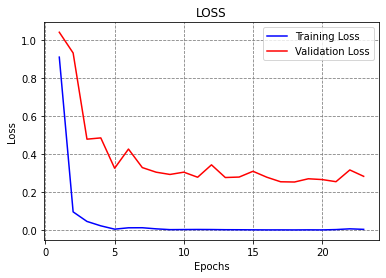

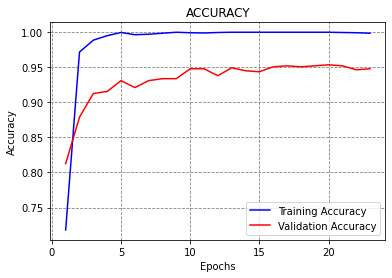

In [ ]:
history = np.load(PROJECT_ROOT_DIR + MODEL_DIR + "trainResNet50HistoryDict.npy",allow_pickle=True).item()


# Plot the loss and accuracy
train_loss = history['loss']
val_loss = history['val_loss']
acc = history['accuracy'] 
val_acc = history['val_accuracy']


epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')


axes = plt.gca()

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()            
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Task 2 -  Implement black-box evasion "Boundary" attacks againts the model we trained.

In this section we're going to apply black-box evasion attack. We're going to apply the attack from a library called **"Adversarial Robustness Toolbox"** often referred as *ART* library. 

In [ ]:
# Installing ART Library (This will install the latest version)
# Use !pip install adversarial-robustness-toolbox==<Version Number> to install specific version of the library
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Similar to the first model we're importing necessary packages. In order to use the saved model we're still importing packages which are already imported. Therefore, if you're planning not to use saved model, it's not necessary to import the package again.

Keep in mind
```
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import BoundaryAttack
```
These are most important, for classifier we're using KerasClassifier, but you can use any other classifier according to your environment such as "**TensorflowV2Classifier**" or "**PytorchClassifier**". And for the attacks we're importing **BoundaryAttack** only



In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

%matplotlib inline
import numpy as np
import keras
from keras.preprocessing import image
from keras.applications.resnet import ResNet50, preprocess_input
from keras.layers import Dense, Flatten
from keras.models import Model
import keras.backend as k
from matplotlib import pyplot as plt
from IPython.display import clear_output

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import BoundaryAttack
from art.utils import to_categorical

## Model Definition
Hewre we're applying mean value to fill up the color channel. In `model` our saved model is being applied. As we're going to use color images for the `clip_values` we're passing the maximum value as 255. However, working on grayscale images will require to pass the `clip_values = (0,1)`

In [ ]:
mean_imagenet = np.zeros([224, 224, 3])
mean_imagenet[...,0].fill(103.939)
mean_imagenet[...,1].fill(116.779)
mean_imagenet[...,2].fill(123.68)
model = load_model(PROJECT_ROOT_DIR + MODEL_DIR +'ResNet50.h5')
classifier = KerasClassifier(clip_values=(0, 255), model=model)

# Get Target and Init Images

In [ ]:
from google.colab.patches import cv2_imshow

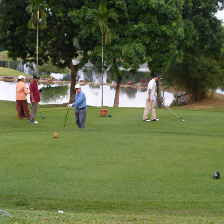

golf_course
(224, 224, 3)


In [ ]:
##Selecting the target image
cv2_imshow(test_images[4])
print(label_names[test_labels[4]])
print(test_images[4].shape)

Here we're going to set our traget image as "**golf_course**" and initial image as "**bedroom**" this will be applied in our targeted attack section.

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Target image is:  6


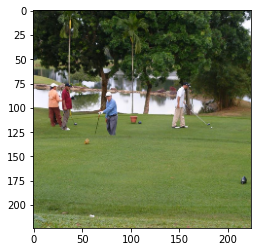

Init image is:  2


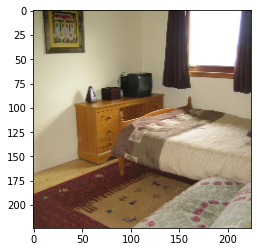

In [ ]:
##Saving target image in specific variable
target_image = test_images[4]
init_image = test_images[6]

print("Target image is: ", np.argmax(classifier.predict(np.reshape(target_image,(1,224,224,3)))))
plt.imshow(target_image.astype(np.uint)[..., ::-1])
plt.show()

print("Init image is: ", np.argmax(classifier.predict(np.reshape(init_image,(1,224,224,3)))))
plt.imshow(init_image.astype(np.uint)[..., ::-1])
plt.show()

## Applying the Attack (Untargeted)
Now, we're going to apply the attack with the iteration step of 200 which is defined as `iter_step = 200` we're going to generate the adversarial images for 5 times and print theeir L2 error with their predicted class label. The parameters passed inside of` BoundaryAttack()` function can be found [here](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#art.attacks.evasion.BoundaryAttack)

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]

Adversarial image at step 0. L2 error 37799.98456781956 and class label:  amusement_park Class Label Number:  1


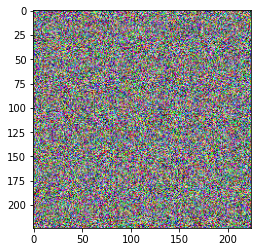

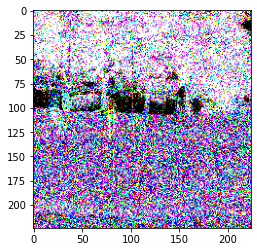

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 200. L2 error 974.1182439879391 and class label:  playground Class Label Number:  9


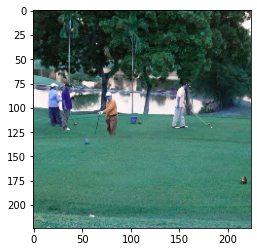

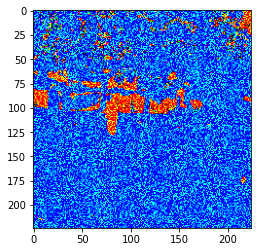

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 400. L2 error 678.1173332166991 and class label:  playground Class Label Number:  9


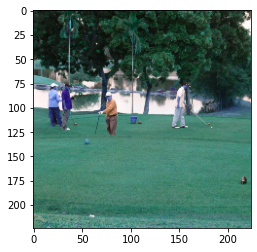

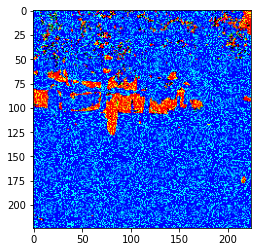

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 600. L2 error 534.3613231444624 and class label:  playground Class Label Number:  9


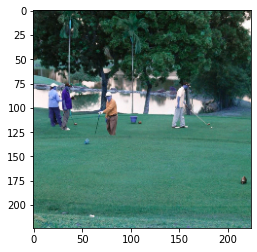

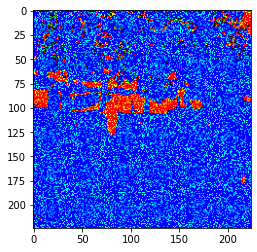

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 800. L2 error 447.60360147728454 and class label:  playground Class Label Number:  9


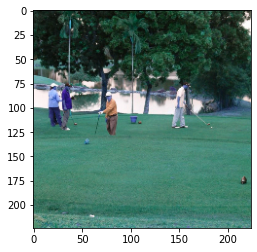

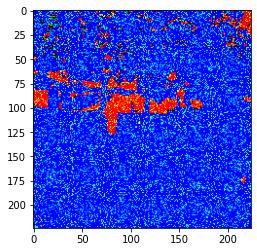

In [ ]:
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.001)
iter_step = 200
x_adv = None
for i in range(5):
    x_adv = attack.generate(x=np.array([target_image[..., ::-1]]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image[..., ::-1], [-1])),
          "and class label: ",label_names[np.argmax(classifier.predict(x_adv))],"Class Label Number: ", np.argmax(classifier.predict(x_adv)))
          
    plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    # np.subsctract
  
    plt.imshow(x_adv[0][..., ::-1].astype(np.uint)-target_image[..., ::-1])
    plt.show(block=True)
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break
      

# Task 3,4 - Applying Targeted Attack & Showing the Result

Here we're going to apply the targeted attack. Our target is to make the model predict "**golf_course**" images as "**bedroom**" The difference in the code is `targeted=True` where it was False for untargeted attack. However, if wanted other parameters could also be fine tuned.

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]

Adversarial image at step 0. L2 error 40627.11338502897 and class label:  bedroom Class Label Number 2


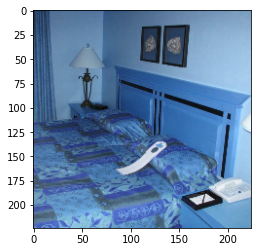

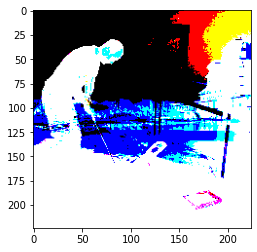

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 200. L2 error 6606.488256556727 and class label:  bedroom Class Label Number 2


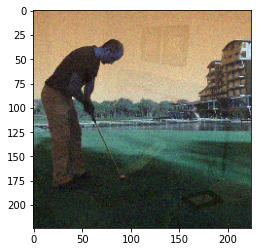

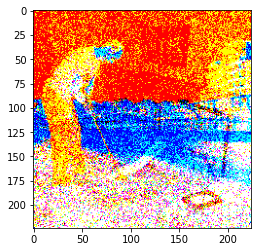

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 400. L2 error 3689.9862437714155 and class label:  bedroom Class Label Number 2


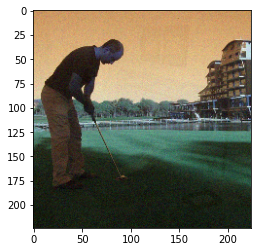

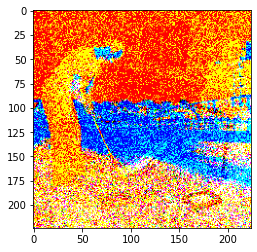

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 600. L2 error 2460.1301657428107 and class label:  bedroom Class Label Number 2


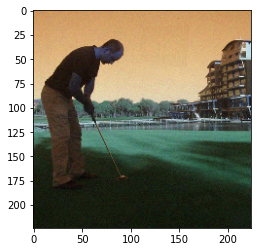

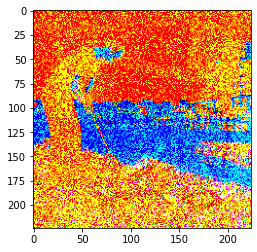

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 800. L2 error 1952.4356437008194 and class label:  bedroom Class Label Number 2


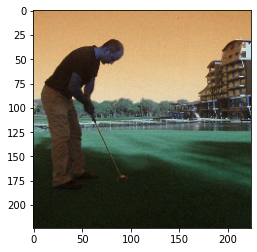

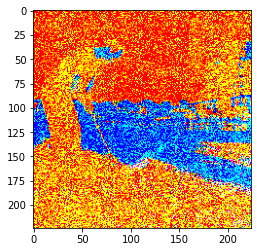

In [ ]:
attack = BoundaryAttack(estimator=classifier, targeted=True, max_iter=0, delta=0.001, epsilon=0.001)
iter_step = 200
x_adv = np.array([init_image[..., ::-1]])

for i in range(5):
    x_adv = attack.generate(x=np.array([target_image[..., ::-1]]), y=to_categorical([2], 11), x_adv_init=x_adv)

    #clear_output()    
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image[..., ::-1], [-1])),
          "and class label: ",label_names[np.argmax(classifier.predict(x_adv))], "Class Label Number",np.argmax(classifier.predict(x_adv)) )
    plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)

    plt.imshow(x_adv[0][..., ::-1].astype(np.uint)-target_image[..., ::-1])
    plt.show(block=True)
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break

#Report Summary

Plots are shown above. Reruning the code might give different images but the class will remain same. For targeted image Bedroom picture was used.

##Boundary Attack 
Boundary attack is a type of attack in adversarial machine learning where an attacker tries to fool a machine learning model by adding imperceptible perturbations to the input data. The objective of the attack is to cause the model to misclassify the input data.

In a boundary attack, the attacker starts with an input data point that is correctly classified by the model and then gradually moves towards the decision boundary of the model by adding small perturbations. The attacker continues to make small adjustments until the model's output changes, indicating that it has crossed the decision boundary.

Boundary attack is considered to be a powerful attack because it can often generate adversarial examples that are misclassified by the model with high confidence. This type of attack is also challenging to defend against since the perturbations can be so small that they are imperceptible to human eyes.

One way to mitigate the impact of boundary attack is to use adversarial training, where the model is trained on a mix of normal and adversarial examples. This helps the model to learn to be more robust against adversarial attacks. Another approach is to use a more robust classification algorithm, such as support vector machines or decision trees, which are less susceptible to boundary attack than neural networks.